In [0]:
import numpy as np
import matplotlib.pyplot as plt

In [0]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

cancer = load_breast_cancer()
x = cancer.data
y = cancer.target

x_train_all, x_test, y_train_all, y_test = train_test_split(x, y, stratify=y, test_size=0.2, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train_all, y_train_all, stratify=y_train_all, test_size=0.2, random_state=42)

In [3]:
print(x_train.shape, x_val.shape)

(364, 30) (91, 30)


In [0]:
class SingleLayer:
  def __init__(self, learning_rate=0.1, l1=0, l2=0):
    self.w = None
    self.b = None
    self.losses = []
    self.val_losses = []
    self.w_history = []
    self.lr = learning_rate
    self.l1 = l1
    self.l2 = l2
  
  def forpass(self, x):
    z = np.dot(x, self.w) + self.b
    return z

  def backprop(self, x, err):
    m = len(x)
    w_grad = np.dot(x.T, err) / m
    b_grad = np.sum(err) / m
    return w_grad, b_grad

  def activation(self, z):
    z = np.clip(z, -100, None)
    a = 1 / (1 + np.exp(-z))
    return a
  
  def reg_loss(self):
    return self.l1 * np.sum(np.abs(self.w)) + self.l2 / 2 * np.sum(self.w**2)

  def fit(self, x, y, epochs=100, x_val=None, y_val=None):
    y = y.reshape(-1, 1)                  # 타깃을 열 벡터로 바꿉니다.
    y_val = y_val.reshape(-1, 1)
    m = len(x)                            # 샘플 개수를 저장합니다.
    self.w = np.ones((x.shape[1], 1))     # 가중치를 초기화합니다.
    self.b = 0                            # 절편을 초기화합니다.
    self.w_history.append(self.w.copy())  # 가중치를 기록합니다.
    # epochs만큼 반복합니다.
    for i in range(epochs):
        z = self.forpass(x)               # 정방향 계산을 수행합니다.
        a = self.activation(z)            # 활성화 함수를 적용합니다.
        err = -(y - a)                    # 오차를 계산합니다.
        # 오차를 역전파하여 그래디언트를 계산합니다.
        w_grad, b_grad = self.backprop(x, err)
        # 그래디언트에서 페널티 항의 미분 값을 더합니다.
        w_grad += (self.l1 * np.sign(self.w) + self.l2 * self.w) / m
        # 가중치와 절편을 업데이트합니다.
        self.w -= self.lr * w_grad
        self.b -= self.lr * b_grad
        # 가중치를 기록합니다.
        self.w_history.append(self.w.copy())
        # 안전한 로그 계산을 위해 클리핑합니다.
        a = np.clip(a, 1e-10, 1-1e-10)
        # 로그 손실과 규제 손실을 더하여 리스트에 추가합니다.
        loss = np.sum(-(y*np.log(a) + (1-y)*np.log(1-a)))
        self.losses.append((loss + self.reg_loss()) / m)
        # 검증 세트에 대한 손실을 계산합니다.
        self.update_val_loss(x_val, y_val)

  def update_val_loss(self, x_val, y_val):
    z = self.forpass(x_val)
    a = self.activation(z)
    a = np.clip(a, 1e-10, 1-1e-10)
    val_loss = np.sum(-(y_val * np.log(a) + (1 - y_val) * np.log(1-a)))
    self.val_losses.append((val_loss + self.reg_loss()) / len(y_val))

  def predict(self, x):
    z = self.forpass(x)
    return z > 0

  def score(self, x, y):
    return np.mean(self.predict(x) == y.reshape(-1 ,1))


In [0]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(x_train)
x_train_scaled = scaler.transform(x_train)
x_val_scaled = scaler.transform(x_val)

In [6]:
single_layer = SingleLayer(l2=0.01)
single_layer.fit(x_train_scaled, y_train, x_val=x_val_scaled, y_val=y_val, epochs=10000)
single_layer.score(x_val_scaled, y_val)

0.978021978021978

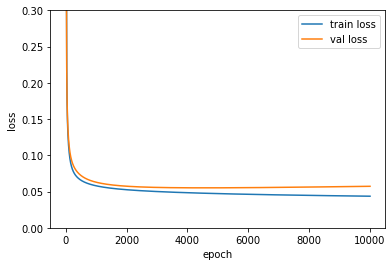

In [7]:
plt.ylim(0, 0.3)
plt.plot(single_layer.losses)
plt.plot(single_layer.val_losses)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'val loss'])
plt.show()

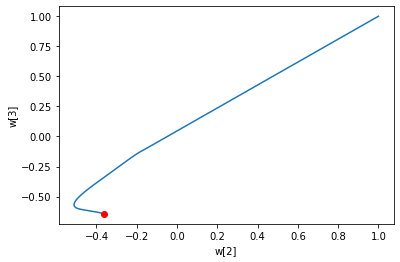

In [8]:
w2 = []
w3 = []
for w in single_layer.w_history:
  w2.append(w[2])
  w3.append(w[3])
plt.plot(w2, w3)
plt.plot(w2[-1], w3[-1], 'ro')
plt.xlabel('w[2]')
plt.ylabel('w[3]')
plt.show()

In [0]:
class DualLayer(SingleLayer):
  def __init__(self, units=10, learning_rate=0.1, l1=0, l2=0):
    self.units = units
    self.w1 = None
    self.b1 = None
    self.w2 = None
    self.b2 = None
    self.a1 = None
    self.losses = []
    self.val_losses = []
    self.lr = learning_rate
    self.l1 = l1
    self.l2 = l2

  def forpass(self, x):
    z1 = np.dot(x, self.w1) + self.b1
    self.a1 = self.activation(z1)
    z2 = np.dot(self.a1, self.w2) + self.b2
    return z2

  def backprop(self, x, err):
    m = len(x)
    w2_grad = np.dot(self.a1.T, err) / m
    b2_grad = np.sum(err) / m
    err_to_hidden = np.dot(err, self.w2.T) * self.a1 * (1 - self.a1)
    w1_grad = np.dot(x.T, err_to_hidden) / m
    b1_grad = np.sum(err_to_hidden, axis=0) / m
    return w1_grad, b1_grad, w2_grad, b2_grad

  def init_weights(self, n_features):
    self.w1 = np.ones((n_features, self.units))
    self.b1 = np.zeros(self.units)
    self.w2 = np.ones((self.units, 1))
    self.b2 = 0

  def fit(self, x, y, epochs=100, x_val=None, y_val=None):
    y = y.reshape(-1, 1)
    y_val = y_val.reshape(-1, 1)
    m = len(x)
    self.init_weights(x.shape[1])

    for i in range(epochs):
      a = self.training(x, y, m)
      a = np.clip(a, 1e-10, 1-1e-10)
      loss = np.sum(-(y * np.log(a) + (1-y) * np.log(1-a)))
      self.losses.append((loss + self.reg_loss()) / m)
      self.update_val_loss(x_val, y_val)

  def training(self, x, y, m):
    z = self.forpass(x)
    a = self.activation(z)
    err = -(y - a)
    w1_grad, b1_grad, w2_grad, b2_grad = self.backprop(x, err)
    
    w1_grad += (self.l1 * np.sign(self.w1) + self.l2 * self.w1) / m
    w2_grad += (self.l1 * np.sign(self.w2) + self.l2 * self.w2) / m
    
    self.w1 -= self.lr * w1_grad
    self.b1 -= self.lr * b1_grad
    
    self.w2 -= self.lr * w2_grad
    self.b2 -= self.lr * b2_grad
    return a
  
  def reg_loss(self):
    return self.l1 * (np.sum(np.abs(self.w1)) + np.sum(np.abs(self.w2))) + \
           self.l2 /2 * (np.sum(self.w1**2) + np.sum(self.w2**2))

In [10]:
dual_layer = DualLayer(l2=0.01)
dual_layer.fit(x_train_scaled, y_train, x_val=x_val_scaled, y_val=y_val, epochs=20000)
dual_layer.score(x_val_scaled, y_val)

0.978021978021978

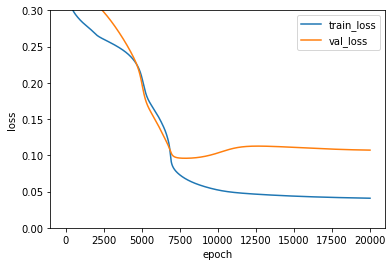

In [11]:
plt.ylim(0, 0.3)
plt.plot(dual_layer.losses)
plt.plot(dual_layer.val_losses)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

In [0]:
class RandomInitNetwork(DualLayer):
  def init_weight(self, n_features):
    np.random.seed(42)
    self.w1 = np.random.normal(0, 1, (n_features, self.units))
    self.b1 = np.zeros(self.units)
    self.w2 = np.random.normal(0, 1, (self.units, 1))
    self.b2 = 0

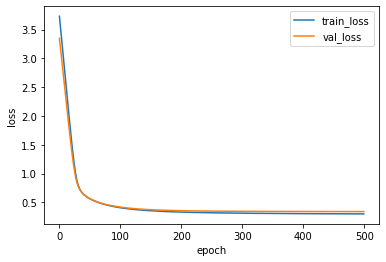

In [37]:
random_init_net = RandomInitNetwork(l2=0.01)
random_init_net.fit(x_train_scaled, y_train, x_val=x_val_scaled, y_val=y_val, epochs=500)

plt.plot(random_init_net.losses)
plt.plot(random_init_net.val_losses)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

In [0]:
class MinibatchNetwork(RandomInitNetwork):
  def __init__(self, units=10, batch_size=32, learning_rate=0.1, l1=0, l2=0):
    super().__init__(units, learning_rate, l1, l2)
    self.batch_size = batch_size

  def fit(self, x, y, epochs=100, x_val=None, y_val=None):
    y_val=y_val.reshape(-1, 1)
    self.init_weights(x.shape[1])
    np.random.seed(42)

    for i in range(epochs):
      loss = 0
      for x_batch, y_batch in self.gen_batch(x, y):
        y_batch = y_batch.reshape(-1, 1)
        m = len(x_batch)
        a = self.training(x_batch, y_batch, m)
        a = np.clip(a, 1e-10, 1-1e-10)
        loss += np.sum(-(y_batch * np.log(a) + (1-y_batch) * np.log(1-a)))
      self.losses.append((loss + self.reg_loss()) / len(x))
      self.update_val_loss(x_val, y_val)

  def gen_batch(self, x, y):
    length = len(x)
    bins = length // self.batch_size
    if length % self.batch_size:
      bins += 1
    indexes = np.random.permutation(np.arange(len(x)))
    x = x[indexes]
    y = y[indexes]
    for i in range(bins):
      start = self.batch_size * i
      end = self.batch_size * (i + 1)
      yield x[start:end], y[start:end]

In [39]:
minibatch_net = MinibatchNetwork(l2=0.01, batch_size=32)
minibatch_net.fit(x_train_scaled, y_train, x_val=x_val_scaled, y_val=y_val, epochs=500)
minibatch_net.score(x_val_scaled, y_val)

0.978021978021978

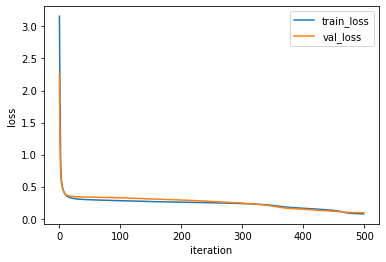

In [40]:
plt.plot(minibatch_net.losses)
plt.plot(minibatch_net.val_losses)
plt.ylabel('loss')
plt.xlabel('iteration')
plt.legend(['train_loss', 'val_loss'])
plt.show()

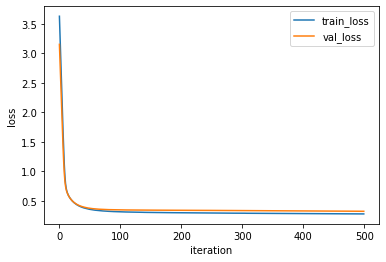

In [41]:
minibatch_net = MinibatchNetwork(l2=0.01, batch_size=128)
minibatch_net.fit(x_train_scaled, y_train, x_val=x_val_scaled, y_val=y_val, epochs=500)
minibatch_net.score(x_val_scaled, y_val)

plt.plot(minibatch_net.losses)
plt.plot(minibatch_net.val_losses)
plt.ylabel('loss')
plt.xlabel('iteration')
plt.legend(['train_loss', 'val_loss'])
plt.show()

In [42]:
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(hidden_layer_sizes=(10,), activation='logistic', solver='sgd', alpha=0.01,
                    batch_size=32, learning_rate_init=0.1, max_iter=500)
mlp.fit(x_train_scaled, y_train)
mlp.score(x_val_scaled, y_val)

0.989010989010989

In [0]:
class MultiClassNetwork:
  def __init__(self, units=10, batch_size=32, learning_rate=0.1, l1=0, l2=0):
    self.units = units
    self.w1 = None
    self.b1 = None
    self.w2 = None
    self.b2 = None
    self.a1 = None
    self.losses = []
    self.val_losses = []
    self.lr = learning_rate
    self.l1 = l1
    self.l2 = l2

  def forpass(self, x):
    z1 = np.dot(x, self.w1) + self.b1
    self.a1 = self.sigmoid(z1)
    z2 = np.dot(self.a1, self.w2) + self.b2
    return z2
  
  def backprop(self, x, err):
    m = len(x)
    w2_grad = np.dot(self.a1.T, err) / m
    b2_grad = np.sum(err) / m
    err_to_hidden = np.dot(err, self.w2.T) * self.a1 * (1 - self.a1)
    w1_grad = np.dot(x.T, err_to_hidden) / m
    b1_grad = np.sum(err_to_hidden, axis=0) / m
    return w1_grad, b1_grad, w2_grad, b2_grad

  def sigmoid(self, z):
    a = 1 / (1 + np.exp(-z))
    return a

  def softmax(self, z):
    exp_z = np.exp(z)
    return exp_z / np.sum(exp_z, axis=1).reshape(-1, 1)

  def init_weights(self, n_features, n_classes):
    self.w1 = np.random.normal(0, 1, (n_features, self.unists))
    self.b1 = np.zeros(self.units)
    self.w2 = np.random.normal(0, 1, (self.units, n_classes))
    self.b2 = np.zeros(n_classes)

  def fit(self, x, y, epochs=100, x_val=None, y_val=None):
    np.random.seed(42)
    self.init_weights(x.shape[1], y.shape[1])
    for i in range(epochs):
      loss = 0
      print('.', end='')
      for x_batch, y_batch in self.gen_batch(x, y):
        a = self.training(x_batch, y_batch)
        a = np.clip(a, 1e-10, 1-1e-10)
        loss += np.sum(-y_batch * np.log(a))
      self.losses.append((loss + self.reg_loss()) / len(x))
      self.update_val_loss(x_val, y_val)
  
  def gen_batch(self, x, y):
    length = len(x)
    bins = length // self.batch_size
    if length % self.batch_size:
      bins += 1
    indexes = np.random.permutation(np.arange(len(x)))
    x = x[indexes]
    y = y[indexes]
    for i in range(bins):
      start = self.batch_size * i
      end = self.batch_size * (i + 1)
      yield x[start:end], y[start:end]

  def training(self, x, y):
    m = len(x)
    z = self.forpass(x)
    a = self.softmax(z)
    err = -(y - a)
    w1_grad, b1_grad, w2_grad, b2_grad = self.backprop(x, err)
    w1_grad += (self.l1 * np.sign(self.w1) + self.l2 * self.w1) / m
    w2_grad += (self.l1 * np.sign(self.w2) + self.l2 * self.w2) / m

    self.w1 -= self.lr * w1_grad
    self.b1 -= self.lr * b1_grad

    self.w2 -= self.lr * w2_grad
    self.b2 -= self.lr * b2_grad
    return a

  def predict(self, x):
    z = self.forpass(x)
    return np.argmax(z, axis=1)

  def score(self, x, y):
    return np.mean(self.predict(x) == np.argmax(y, axis=1))

  def reg_loss(self):
    return self.l1 * (np.sum(np.abs(self.w1)) + np.sum(np.abs(self.w2))) + \
           self.l2 / 2 * (np.sum(self.w1**2) + np.sum(self.w2**2))

  def update_val_loss(self, x_val, y_val):
    z = self.forpass(x_val)
    a = self.softmax(z)
    a = np.clip(a, 1e-10, 1-1e-10)
    val_loss = np.sum(-y_val * np.log(a))
    self.val_losses.append((val_loss + self.reg_loss()) / len(y_val))

